# Analysing the calibration of the ConvNext_BS model on BirdSet

In [24]:
# Load predictions from each test set by looping over all folders in /workspace/logs/predictions/convnext_bs and load the .pkl files

# load data in dict form: data[<dataset_name>] = (predictions, targets, metadata)
import os
import torch
from matplotlib import pyplot as plt
from uncertainbird.utils.misc import load_dump

data = {}

log_dir = "/workspace/logs/predictions/convnext_bs"
dataset_names = sorted(
    [d for d in os.listdir(log_dir) if os.path.isdir(os.path.join(log_dir, d))]
)

# colormap without red (tab10 index 3 is red)
colors = plt.cm.tab10
skip_index = 3
available_indices = [i for i in range(colors.N) if i != skip_index]
dataset_colors = {}

for i, ds in enumerate(dataset_names):
    data[ds] = {}
    color_idx = available_indices[i % len(available_indices)]
    dataset_colors[ds] = colors(color_idx)

    ds_path = os.path.join(log_dir, ds)
    pkl_files = [f for f in os.listdir(ds_path) if f.endswith(".pkl")]
    if not pkl_files:
        continue
    # pick most recent file
    pkl_files.sort(
        key=lambda f: os.path.getmtime(os.path.join(ds_path, f)), reverse=True
    )
    file_path = os.path.join(ds_path, pkl_files[0])
    preds, t, metadata = load_dump(file_path)
    data[ds]["predictions"] = preds
    data[ds]["targets"] = t.int()
    data[ds]["metadata"] = metadata
    data[ds]["color"] = dataset_colors[ds]

# concatenate
valid_keys = [
    k
    for k, v in data.items()
    if isinstance(v, dict)
    and "predictions" in v
    and "targets" in v
    and isinstance(v["predictions"], torch.Tensor)
    and isinstance(v["targets"], torch.Tensor)
]

if not valid_keys:
    raise ValueError("No datasets with both 'predictions' and 'targets' present.")

# optionally report skipped datasets
skipped = [k for k in data.keys() if k not in valid_keys]
if skipped:
    print("Skipped datasets (missing predictions/targets):", skipped)

predictions = torch.cat([data[k]["predictions"] for k in valid_keys], dim=0)
targets = torch.cat([data[k]["targets"] for k in valid_keys], dim=0)

data = {k: data[k] for k in valid_keys}

predictions.shape, targets.shape

Loaded data with 12000 samples
Predictions shape: torch.Size([12000, 9736])
Targets shape: torch.Size([12000, 9736])
Model info: {'class_name': 'MultilabelModule', 'task': 'multilabel', 'num_classes': None}
Loaded data with 539 samples
Predictions shape: torch.Size([539, 9736])
Targets shape: torch.Size([539, 9736])
Model info: {'class_name': 'MultilabelModule', 'task': 'multilabel', 'num_classes': None}
Loaded data with 24480 samples
Predictions shape: torch.Size([24480, 9736])
Targets shape: torch.Size([24480, 9736])
Model info: {'class_name': 'MultilabelModule', 'task': 'multilabel', 'num_classes': None}
Loaded data with 15120 samples
Predictions shape: torch.Size([15120, 9736])
Targets shape: torch.Size([15120, 9736])
Model info: {'class_name': 'MultilabelModule', 'task': 'multilabel', 'num_classes': None}
Loaded data with 4560 samples
Predictions shape: torch.Size([4560, 9736])
Targets shape: torch.Size([4560, 9736])
Model info: {'class_name': 'MultilabelModule', 'task': 'multilab

(torch.Size([117092, 9736]), torch.Size([117092, 9736]))

In [25]:
data["HSN"].keys()

dict_keys(['predictions', 'targets', 'metadata', 'color'])

## Global - all labels incl. non present target labels

In [6]:
from uncertainbird.utils.plotting import print_metrics

metrics = print_metrics(predictions, targets)

/home/vscode/.cache/pypoetry/virtualenvs/birdset-xS3fZVNL-py3.10/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/vscode/.cache/pypoetry/virtualenvs/birdset-xS3fZVNL-py3.10/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Accuracy: tensor(0.9999)
cmAP: tensor(0.2256)
Precision: tensor(0.0156)
Recall: tensor(0.0035)
F1 Score: tensor(0.0047)
AUROC: tensor(0.0353)
ECE: tensor(0.0002)
ECE Weighted: tensor(0.0233)
ECE Top-3: tensor(0.0642)
ECE Top-5: tensor(0.0490)
ECE Top-10: tensor(0.0365)
ECE Top-21: tensor(0.0255)


<Axes: title={'center': 'Reliability Diagram - ConvNeXt_BS on BirdSet | ECE weighted = 2.33%'}, xlabel='Mean Predicted Probability', ylabel='Fraction of Positives'>

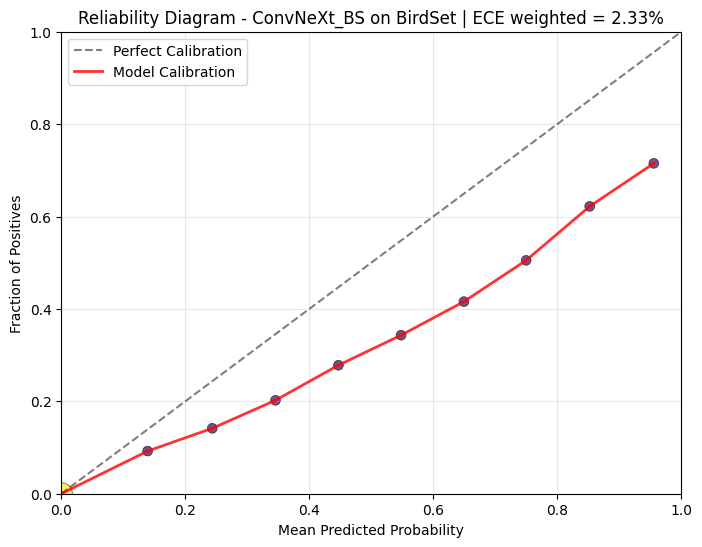

In [7]:
# reliability diagram
from uncertainbird.utils.plotting import plot_reliability_diagram

plot_reliability_diagram(
    predictions,
    targets,
    n_bins=10,
    title=f"Reliability Diagram - ConvNeXt_BS on BirdSet | ECE weighted = {metrics['ece_weighted']*100:.2f}%",
)

## Globael - only classes present in the target labels

```python

In [8]:
# how many classes are represented by atleast one sample in the targets?
print("Number of classes in targets:", targets.sum(dim=0).gt(0).sum().item())
# how many classes are represented by atleast 5 samples in the targets?
print(
    "Number of classes with atleast 5 samples in targets:",
    targets.sum(dim=0).ge(5).sum().item(),
)

Number of classes in targets: 383
Number of classes with atleast 5 samples in targets: 334


In [9]:
# select only target classes
predictions_targetclasses = predictions[:, targets.sum(dim=0).gt(0)]
targets_targetclasses = targets[:, targets.sum(dim=0).gt(0)]

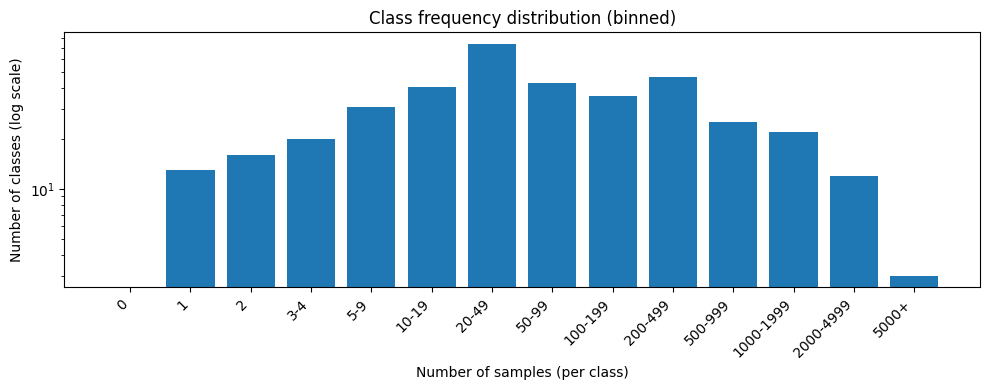

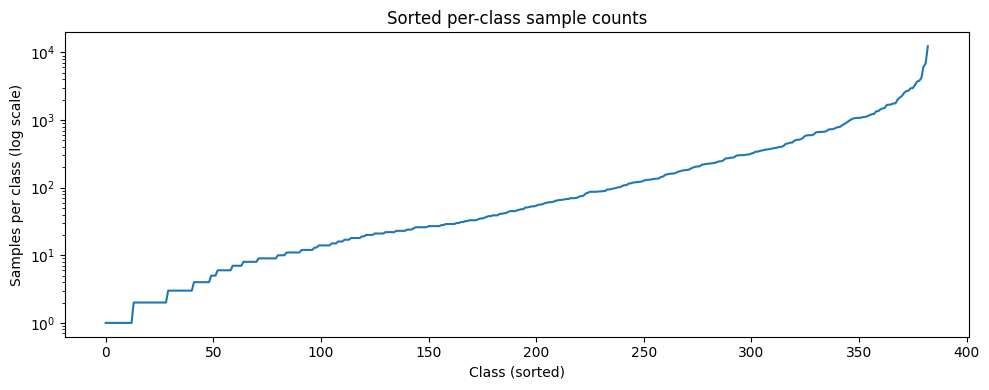

In [10]:
from uncertainbird.utils.plotting import plot_class_frequency

plot_class_frequency(targets_targetclasses)

In [11]:
from uncertainbird.utils.plotting import print_metrics

metrics_targetclasses = print_metrics(predictions_targetclasses, targets_targetclasses)

Accuracy: tensor(0.9972)
cmAP: tensor(0.2256)
Precision: tensor(0.3963)
Recall: tensor(0.0884)
F1 Score: tensor(0.1202)
AUROC: tensor(0.8968)
ECE: tensor(0.0027)
ECE Weighted: tensor(0.0233)
ECE Top-3: tensor(0.0642)
ECE Top-5: tensor(0.0490)
ECE Top-10: tensor(0.0365)
ECE Top-21: tensor(0.0255)


<Axes: title={'center': 'Reliability Diagram - ConvNeXt_BS on BirdSet`s target classes | ECE weighted = 2.33%'}, xlabel='Mean Predicted Probability', ylabel='Fraction of Positives'>

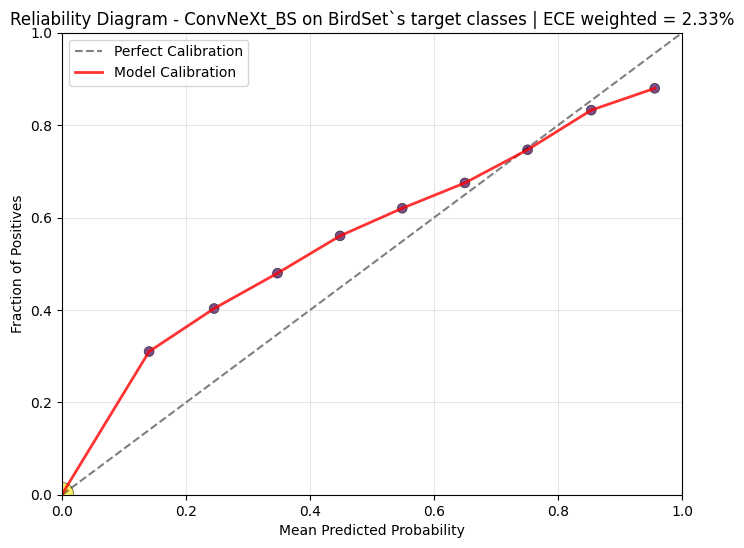

In [13]:
# reliability diagram
from uncertainbird.utils.plotting import plot_reliability_diagram

plot_reliability_diagram(
    predictions_targetclasses,
    targets_targetclasses,
    n_bins=10,
    title=f"Reliability Diagram - ConvNeXt_BS on BirdSet`s target classes | ECE weighted = {metrics_targetclasses['ece_weighted']*100:.2f}%",
)

## Class-wise Calibration Plots

In [27]:
# only select classes with target labels
for key in list(data.keys()):
    # keep the dict structure; only replace the predictions/targets tensors
    preds = data[key]["predictions"][:, targets.sum(dim=0).gt(0)]
    tars = data[key]["targets"][:, targets.sum(dim=0).gt(0)]
    data[key]["predictions"] = preds
    data[key]["targets"] = tars
    # metadata and color remain unchanged

In [28]:
# compute metrics
for key in data:
    print("Computing metrics for", key)
    preds = data[key]["predictions"]
    tar = data[key]["targets"]
    data[key]["metrics"] = print_metrics(preds, tar)

Computing metrics for HSN


/home/vscode/.cache/pypoetry/virtualenvs/birdset-xS3fZVNL-py3.10/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/vscode/.cache/pypoetry/virtualenvs/birdset-xS3fZVNL-py3.10/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Accuracy: tensor(0.9987)
cmAP: tensor(0.4914)
Precision: tensor(0.0321)
Recall: tensor(0.0048)
F1 Score: tensor(0.0076)
AUROC: tensor(0.0487)
ECE: tensor(0.0016)
ECE Weighted: tensor(0.1179)
ECE Top-3: tensor(0.1175)
ECE Top-5: tensor(0.0854)
ECE Top-10: tensor(0.0472)
ECE Top-21: tensor(0.0229)
Computing metrics for NBP
Accuracy: tensor(0.9962)
cmAP: tensor(0.6057)
Precision: tensor(0.0817)
Recall: tensor(0.0221)
F1 Score: tensor(0.0315)
AUROC: tensor(0.1213)
ECE: tensor(0.0037)
ECE Weighted: tensor(0.0327)
ECE Top-3: tensor(0.0555)
ECE Top-5: tensor(0.0517)
ECE Top-10: tensor(0.0463)
ECE Top-21: tensor(0.0413)
Computing metrics for NES
Accuracy: tensor(0.9989)
cmAP: tensor(0.3430)
Precision: tensor(0.1009)
Recall: tensor(0.0349)
F1 Score: tensor(0.0452)
AUROC: tensor(0.2038)
ECE: tensor(0.0014)
ECE Weighted: tensor(0.0246)
ECE Top-3: tensor(0.0497)
ECE Top-5: tensor(0.0363)
ECE Top-10: tensor(0.0238)
ECE Top-21: tensor(0.0148)
Computing metrics for PER
Accuracy: tensor(0.9937)
cmAP: 

### Reliability Diagram
```

#### Combined

<Axes: title={'center': 'Combined Reliability Diagram - ConvNeXt_BS on BirdSet'}, xlabel='Mean Predicted Probability', ylabel='Fraction of Positives'>

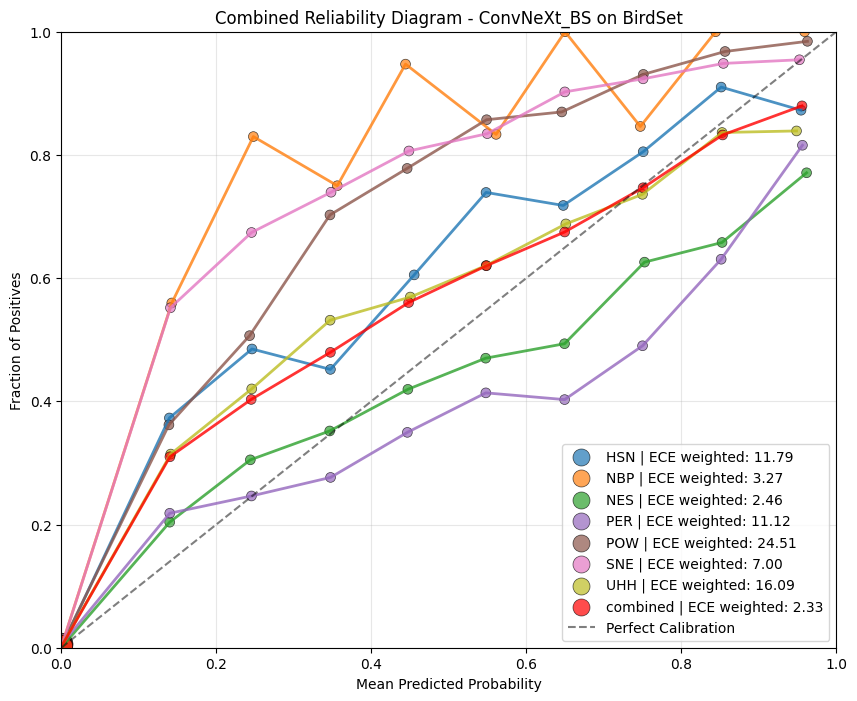

In [49]:
from uncertainbird.utils.plotting import plot_combined_reliability_diagram

# add average / combined data of all datasets
data["combined"] = {
    "predictions": predictions_targetclasses,
    "targets": targets_targetclasses,
    "metadata": None,
    "metrics": metrics_targetclasses,
    "color": "red",  # color for combined plot
}

plot_combined_reliability_diagram(
    data, n_bins=10, title="Combined Reliability Diagram - ConvNeXt_BS on BirdSet"
)

#### Per class

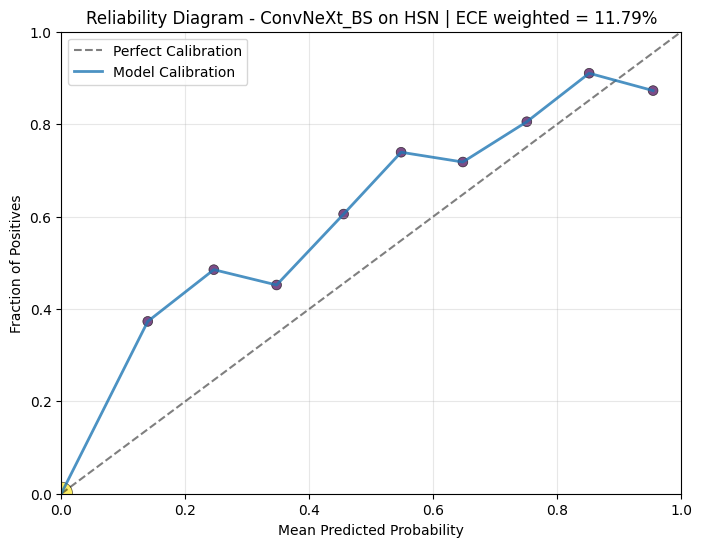

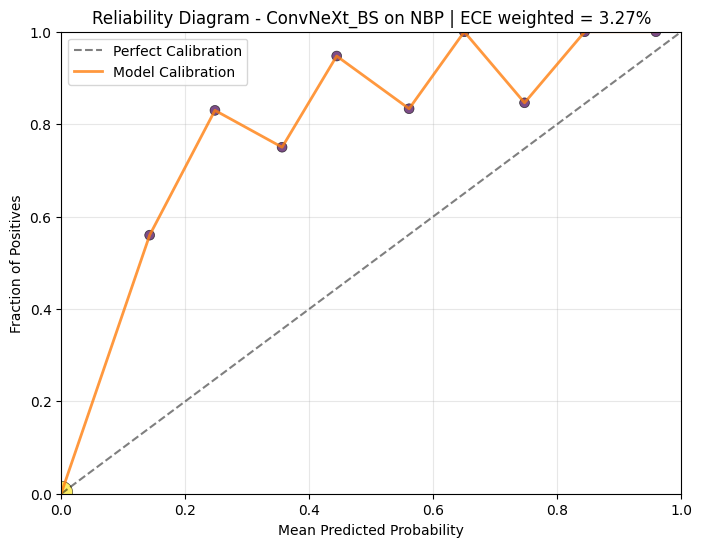

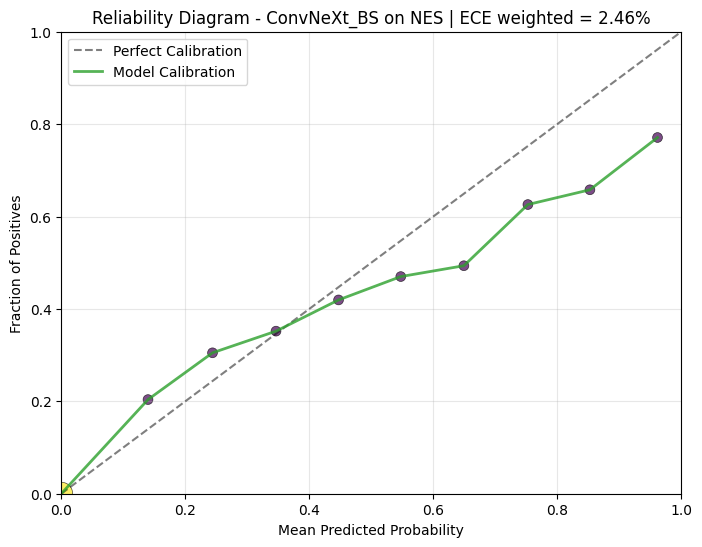

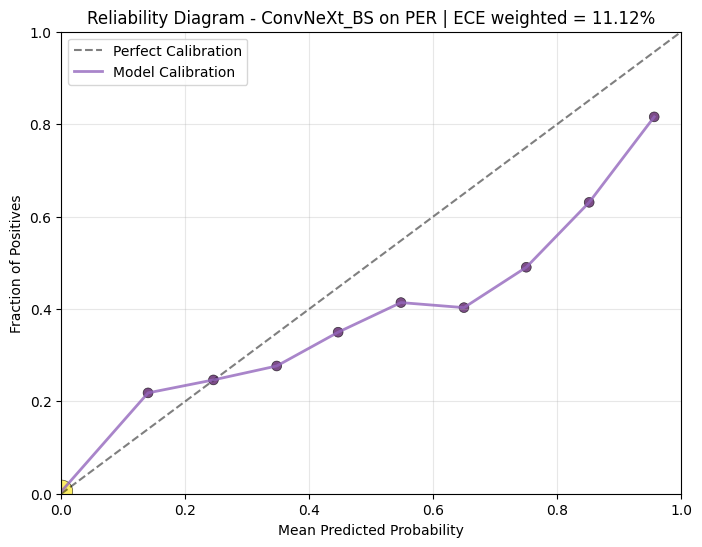

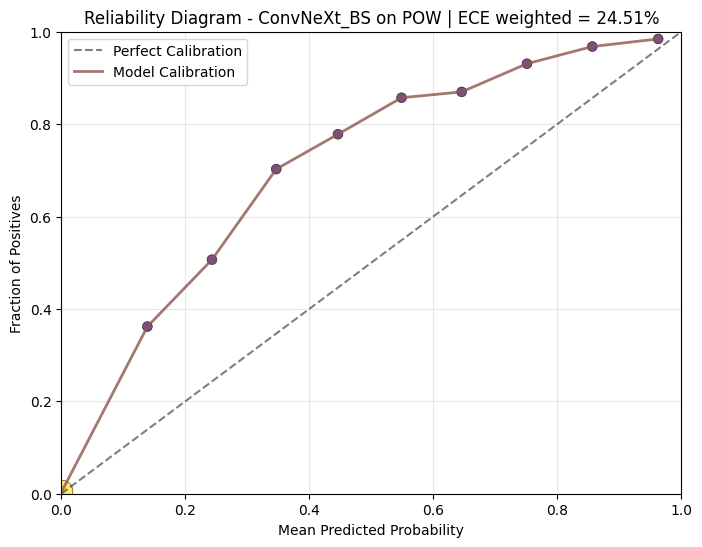

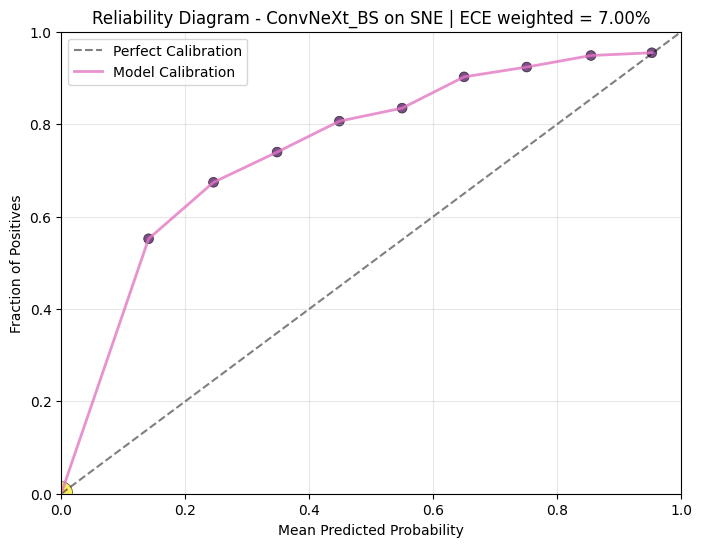

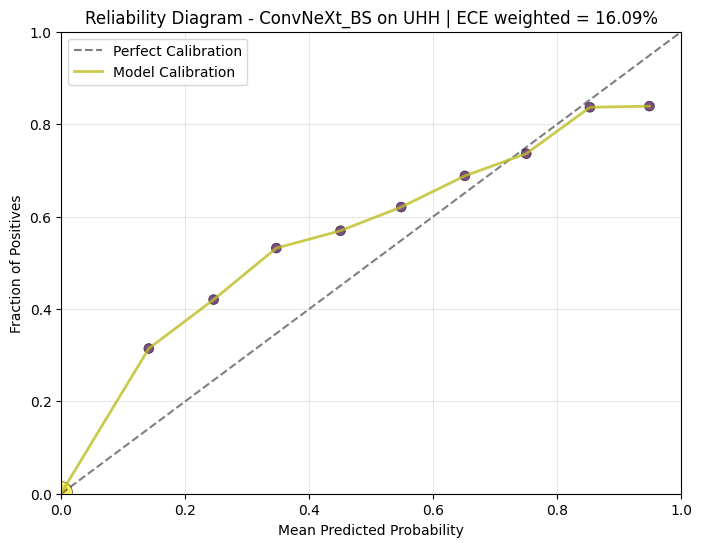

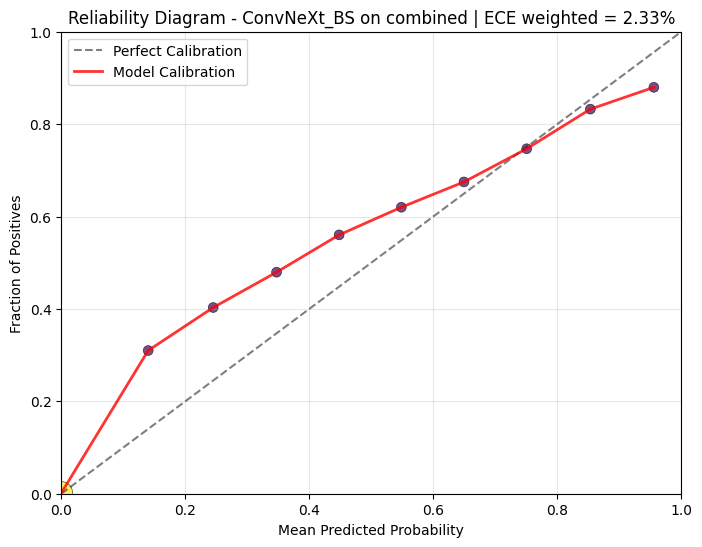

In [37]:
for key in data:
    plot_reliability_diagram(
        data[key]["predictions"],
        data[key]["targets"],
        n_bins=10,
        title=f"Reliability Diagram - ConvNeXt_BS on {key} | ECE weighted = {data[key]['metrics']['ece_weighted']*100:.2f}%",
        color=data[key].get("color", "red"),
    )

In [45]:
from uncertainbird.utils.misc import class_wise_statistics

preds = predictions_targetclasses.float()
tar = targets_targetclasses.int()

class_stats = class_wise_statistics(preds, tar, n_bins=10)

In [46]:
class_stats

{'mean': tensor([1.1088e-03, 8.5397e-04, 1.6295e-03, 1.3474e-03, 5.7576e-03, 7.2983e-05,
         1.7206e-05, 3.2313e-04, 1.6568e-03, 3.4354e-04, 1.9665e-04, 4.5350e-04,
         6.1517e-05, 5.7296e-04, 5.0010e-04, 5.5743e-05, 4.6643e-04, 2.8610e-05,
         1.4016e-04, 2.1450e-04, 1.3189e-04, 2.2547e-04, 7.3733e-04, 1.9862e-04,
         2.2451e-05, 1.4661e-05, 1.0296e-04, 2.9985e-03, 4.6485e-04, 9.2085e-04,
         4.4898e-04, 5.5198e-04, 8.5864e-05, 4.7803e-04, 1.2042e-04, 1.1290e-04,
         9.4094e-04, 3.2533e-04, 3.8921e-04, 7.6974e-04, 7.4035e-04, 6.3455e-04,
         1.0807e-03, 1.0070e-03, 8.4627e-04, 3.5712e-04, 4.6465e-04, 3.7955e-04,
         1.6257e-04, 2.4418e-06, 1.0587e-04, 8.2101e-04, 1.3279e-04, 5.7474e-04,
         7.1381e-06, 9.7605e-04, 2.5471e-04, 1.9750e-04, 4.6222e-04, 1.0025e-03,
         1.3216e-03, 2.4576e-04, 7.0724e-05, 1.9095e-04, 8.5988e-04, 4.3286e-05,
         1.5848e-04, 2.4962e-04, 5.2417e-04, 4.9030e-04, 9.6607e-05, 1.2565e-04,
         1.7760e-04,

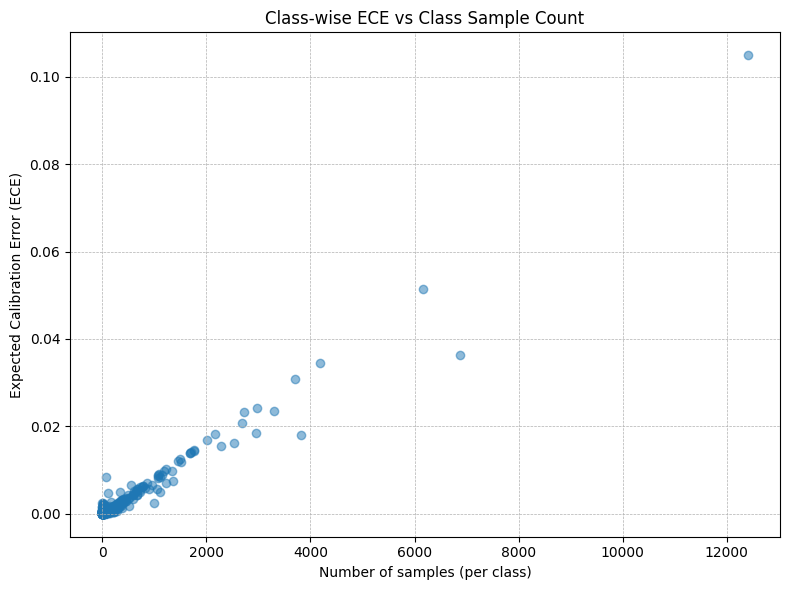

In [47]:
# plot ece vs class sample count
plt.figure(figsize=(8, 6))
plt.scatter(class_stats["positive_samples"], class_stats["ece"], alpha=0.5)
plt.xlabel("Number of samples (per class)")
plt.ylabel("Expected Calibration Error (ECE)")
plt.title("Class-wise ECE vs Class Sample Count")
plt.grid(True, ls="--", lw=0.5)
plt.tight_layout()
plt.show()

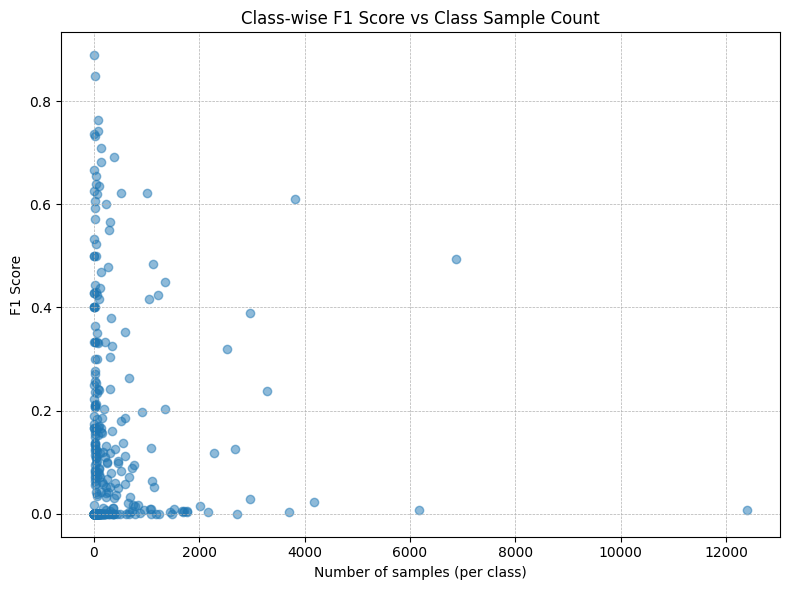

In [48]:
# f1 vs class sample count
plt.figure(figsize=(8, 6))
plt.scatter(class_stats["positive_samples"], class_stats["f1_score"], alpha=0.5)
plt.xlabel("Number of samples (per class)")
plt.ylabel("F1 Score")
plt.title("Class-wise F1 Score vs Class Sample Count")
plt.grid(True, ls="--", lw=0.5)
plt.tight_layout()